# **Exercise 4: Non-Linear Advection-Diffusion Equation**

In [30]:
import numpy as np
import matplotlib.pyplot as plt

## Task 2: compute solution and order of convergence

In [31]:
# Exact solution
def exact_solution(x, t, eps):
    return -np.tanh((x + 0.5 - t)/(2*eps)) + 1.0

def g_L(t, eps):
    return exact_solution(-1.0, t, eps)

def g_R(t, eps):
    return exact_solution(+1.0, t, eps)

# --- Assuming 'step' function is defined as in your previous snippet ---
# def step(u, dt, h, eps):
#     u_new = np.copy(u)
#     for i in range(1, len(u)-1):
#         # Advection term - upwind scheme
#         if u[i] >= 0:
#             flux_adv = u[i] * (u[i] - u[i-1])
#         else:
#             flux_adv = u[i] * (u[i+1] - u[i])

#         # Diffusion term - central difference
#         flux_diff = (u[i+1] - 2*u[i] + u[i-1])

#         # Update solution using forward Euler
#         u_new[i] = u[i] - dt/h * flux_adv + eps*dt/h**2 * flux_diff
#     return u_new
# ----------------------------------------------------------------------

def step(u, dt, h, eps):
    u_new = u.copy() # Start with a copy of the current solution

    # Indices for interior points
    i = np.arange(1, len(u) - 1)

    # --- Advection Term (Upwind Scheme) ---
    advection_term_val = np.zeros_like(u[1:-1])

    # Case 1: u[i] >= 0 (flow from left)
    mask_pos = (u[1:-1] >= 0)
    advection_term_val[mask_pos] = u[1:-1][mask_pos] * (u[1:-1][mask_pos] - u[:-2][mask_pos])

    # Case 2: u[i] < 0 (flow from right)
    mask_neg = (u[1:-1] < 0)
    advection_term_val[mask_neg] = u[1:-1][mask_neg] * (u[2:][mask_neg] - u[1:-1][mask_neg])


    # --- Diffusion Term (Central Difference) ---
    diffusion_term_val = (u[2:] - 2*u[1:-1] + u[:-2])

    # --- Update Interior Points ---
    u_new[1:-1] = u[1:-1] - (dt / h) * advection_term_val + (eps * dt / h**2) * diffusion_term_val

    return u_new

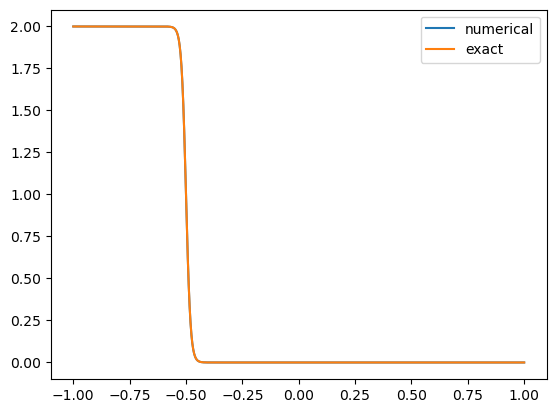

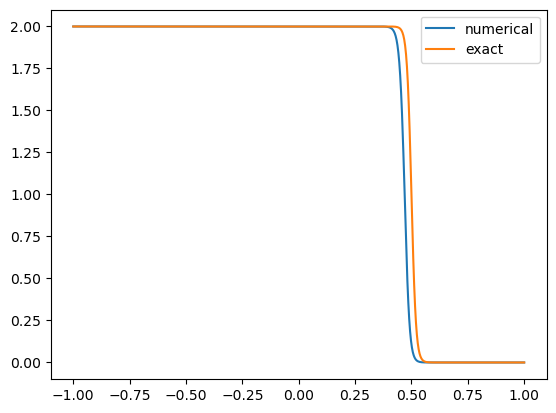

0.22892422786401972


In [32]:
# Domain
a = -1
b = 1

# Parameters
eps = 0.01
Cr_adv = 0.8  # safety factor for advection
Cr_diff = 0.5  # safety factor for diffusion

# Spatial mesh
N = 999
h = (b-a)/(N+1)
xi = np.arange(a,b+h,h)

# Temporal mesh
t_in, t_final = 0, 1

# Initial condition
u = exact_solution(xi, t_in, eps)

# Time steps
dt_adv = Cr_adv*h/np.max(np.abs(u))
dt_diff = Cr_diff*h**2/(2*eps)
dt = min(dt_adv, dt_diff)

# Save solution at each time step
u_sol = []
u_sol.append(u)

# Save times array as well
times = []

# Time iteration
# We can't do a for loop as we have to recalculate dt at each iteration
ti = 0.0
while ti < t_final:

    # Recalculate time step at each iteration for stability
    max_u = np.max(np.abs(u))
    dt_adv = Cr_adv*h/np.max(np.abs(u))
    dt_diff = Cr_diff*h**2/(2*eps)
    dt = min(dt_adv, dt_diff)

    # Make sure we don't overshoot the final time
    if ti + dt > t_final:
        dt = t_final - ti
    
    u = u.copy()

    # Apply boundary conditions
    u[0] = g_L(ti, eps)  # g_L(t)
    u[-1] = g_R(ti, eps)  # g_R(t)

    # Update solution
    u_new = step(u, dt, h, eps)
    u = u_new.copy()

    # Update time
    ti += dt

    # Save solution
    u_sol.append(u_new)
    times.append(ti)


# Plot exact solution and numerical solution at t=tfinal
plt.plot(xi,u_sol[0],label='numerical')
plt.plot(xi,exact_solution(xi,0,eps),label='exact')
plt.legend()
plt.show()

plt.plot(xi,u_sol[-1],label='numerical')
plt.plot(xi,exact_solution(xi,1,eps),label='exact')
plt.legend()
plt.show()

err = np.sqrt(np.sum((u - exact_solution(xi, t_final, eps))**2) * h)
print(err)

Convergence Test

In [69]:
# Convergence study parameters
N_values = [199, 399,599, 799,1199,1399,1599]
h_values = [2 / (N + 1) for N in N_values]
eps = 0.01
t_final = 1.0
Cr_adv = 0.5
Cr_diff = 0.5

hs = []
errors = []
dts = []  # 🔧 Move this outside the loop to store one dt per N

for N in N_values:
    # Grid
    a, b = -1, 1
    h = (b - a) / (N + 1)
    x = np.linspace(a, b, N + 2)
    u = exact_solution(x, 0, eps)
    t = 0.0
    dt_sum = 0
    step_count = 0
    dt_list = []

    # Time-stepping loop
    while t < t_final:
        max_u = np.max(np.abs(u))
        dt_adv = Cr_adv * h / max(max_u, 1e-10)
        dt_diff = Cr_diff * h**2 / (2 * eps)
        dt = min(dt_adv, dt_diff)
        if t + dt > t_final:
            dt = t_final - t

        # Apply boundary conditions
        u[0] = g_L(t, eps)
        u[-1] = g_R(t, eps)

        # Time integration step
        u = step(u, dt, h, eps)
        t += dt

        dt_sum += dt
        step_count += 1
        dt_list.append(dt)

    # Average dt for this run
    dt_avg = dt_sum / step_count
    print (dt_list)
    print (max(dt_list))
    print(dt_avg)
    dts.append(dt_avg)
    #dts.append(max(dt_list))

    # Final BCs and error
    u[0] = g_L(t_final, eps)
    u[-1] = g_R(t_final, eps)
    u_ex = exact_solution(x, t_final, eps)
    err = np.max(np.abs(u - u_ex))

    hs.append(h)
    errors.append(err)


[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,

     N          h         dt        L∞ Error       Rate
   199     0.0100 0.00249377    1.988734e+00
   399     0.0050 0.00062461    1.850985e+00     0.1036
   599     0.0033 0.00027778    1.636644e+00     0.3035
   799     0.0025 0.00015623    1.425351e+00     0.4805
  1199     0.0017 0.00006944    1.101341e+00     0.6360
  1399     0.0014 0.00005102    9.825739e-01     0.7402
  1599     0.0013 0.00003906    8.847830e-01     0.7851


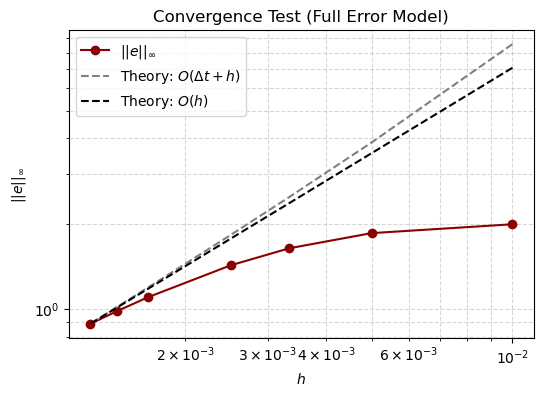

In [70]:

# Compute convergence rates
rates = [np.log(errors[i - 1] / errors[i]) / np.log(hs[i - 1] / hs[i]) for i in range(1, len(errors))]

# Print convergence table
print(f"{'N':>6} {'h':>10} {'dt':>10} {'L∞ Error':>15} {'Rate':>10}")
for i, N in enumerate(N_values):
    h = hs[i]
    dt = dts[i]
    e = errors[i]
    if i > 0:
        r = rates[i - 1]
        print(f"{N:6d} {h:10.4f} {dt:10.8f} {e:15.6e} {r:10.4f}")
    else:
        print(f"{N:6d} {h:10.4f} {dt:10.8f} {e:15.6e}")

# Plot results
h_arr = np.array(hs)
dt_arr = np.array(dts)
e_arr = np.array(errors)

# Build theoretical error model
ref_C = e_arr[-1] / (dt_arr[-1] + h_arr[-1])
ref_h = e_arr[-1] / (h_arr[-1])
theory = ref_C * (dt_arr + h_arr)

plt.figure(figsize=(6, 4))
plt.loglog(h_arr, e_arr, '-o', label=r'$||e||_\infty$', color='darkred')
plt.loglog(h_arr, theory, '--', label=r'Theory: $O(\Delta t + h)$', color='gray')
plt.loglog(h_arr, ref_h *h_arr, '--', label=r'Theory: $O(h)$', color='black')
plt.xlabel(r'$h$')
plt.ylabel(r'$||e||_\infty$')
plt.title('Convergence Test (Full Error Model)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()
